In [25]:
import os, sys
import importlib
import logging
from pathlib import Path
import json

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise

PLOT_DIR = Path(os.path.join(os.path.dirname(os.getcwd()), "plots"))
assert PLOT_DIR.is_dir()

BIN_DIR = Path(os.path.join(os.path.dirname(os.getcwd()), "bin"))
assert BIN_DIR.is_dir()
sys.path.append(str(BIN_DIR))
from sample import build_datasets

SRC_DIR = Path(os.path.join(os.path.dirname(os.getcwd()), "protdiff"))
assert SRC_DIR.is_dir()
sys.path.append(str(SRC_DIR))
import angles_and_coords as ac
import beta_schedules
import modelling
import sampling

logging.basicConfig(level=logging.INFO)

MODEL_DIR = Path("/home/wukevin/projects/protdiff_results/models/coords/results")
MODEL_DIR

PosixPath('/home/wukevin/projects/protdiff_results/models/coords/results')

In [55]:
PLOT_SUBDIR = PLOT_DIR / "cartesian_baseline_pairwise_dists"
os.makedirs(PLOT_SUBDIR, exist_ok=True)

In [2]:
with open(MODEL_DIR / "training_args.json") as source:
    training_args = json.load(source)
training_args

{'results_dir': '/home/wukevin/projects/protdiff_results/models/coords/results',
 'angles_definitions': 'cart-coords',
 'max_seq_len': 128,
 'min_seq_len': 40,
 'trim_strategy': 'randomcrop',
 'timesteps': 1000,
 'variance_schedule': 'cosine',
 'variance_scale': 1.0,
 'time_encoding': 'gaussian_fourier',
 'num_hidden_layers': 12,
 'hidden_size': 384,
 'intermediate_size': 768,
 'num_heads': 12,
 'position_embedding_type': 'relative_key',
 'dropout_p': 0.1,
 'decoder': 'mlp',
 'gradient_clip': 1.0,
 'batch_size': 64,
 'lr': 5e-05,
 'loss': 'smooth_l1',
 'l2_norm': 0.0,
 'l1_norm': 0.0,
 'circle_reg': 0.0,
 'min_epochs': 10000,
 'max_epochs': 10000,
 'early_stop_patience': 0,
 'lr_scheduler': 'LinearWarmup',
 'use_swa': False,
 'subset': None,
 'exhaustive_validation_t': False,
 'syn_noiser': '',
 'single_angle_debug': -1,
 'single_timestep_debug': False,
 'cpu_only': False,
 'ngpu': -1,
 'write_valid_preds': False,
 'dryrun': True,
 'multithread': True}

In [3]:
# Load the training test dataset
train_dset, valid_dset, test_dset = build_datasets(training_args)
train_dset[0]

INFO:root:Clean dataset class: <class 'datasets.CathCanonicalCoordsDataset'>
INFO:root:Creating data splits: ['train', 'validation', 'test']
INFO:root:Computing full dataset of 31885 with 32 threads
INFO:root:Saving full dataset to cache at /home/wukevin/projects/protdiff/protdiff/cache_canonical_structures_0c168eba3a43e4105949eda7db392573.pkl
INFO:root:Removing structures shorter than 40 residues excludes 536/30931 --> 30395 sequences
INFO:root:Split train contains 24316 structures
INFO:root:Length of angles: 40-1202, mean 153.14570653067938
INFO:root:Loading cached full dataset from /home/wukevin/projects/protdiff/protdiff/cache_canonical_structures_0c168eba3a43e4105949eda7db392573.pkl
INFO:root:Removing structures shorter than 40 residues excludes 536/30931 --> 30395 sequences
INFO:root:Split validation contains 3039 structures
INFO:root:Length of angles: 40-869, mean 154.26028298782495
INFO:root:Loading cached full dataset from /home/wukevin/projects/protdiff/protdiff/cache_canonic

{'coords': tensor([[ 7.3180e+00,  1.2245e+01,  3.5136e+01],
         [ 9.2940e+00,  9.4780e+00,  3.3397e+01],
         [ 1.0216e+01,  1.1987e+01,  3.0823e+01],
         [ 1.2926e+01,  1.3494e+01,  3.3097e+01],
         [ 1.6155e+01,  1.1274e+01,  3.3036e+01],
         [ 1.6253e+01,  1.1033e+01,  3.6816e+01],
         [ 1.2656e+01,  9.7680e+00,  3.7293e+01],
         [ 1.2699e+01,  6.0840e+00,  3.6583e+01],
         [ 9.0990e+00,  4.7210e+00,  3.7103e+01],
         [ 8.7550e+00,  1.3800e+00,  3.9045e+01],
         [ 1.2189e+01,  4.1000e-02,  4.0136e+01],
         [ 1.2816e+01, -2.2030e+00,  4.3079e+01],
         [ 1.5337e+01, -1.2870e+00,  4.5753e+01],
         [ 1.7662e+01, -3.9230e+00,  4.4310e+01],
         [ 1.7387e+01, -2.9490e+00,  4.0604e+01],
         [ 1.8050e+01,  6.6000e-01,  4.1558e+01],
         [ 2.1295e+01, -5.7000e-01,  4.3123e+01],
         [ 2.2197e+01, -2.2110e+00,  3.9776e+01],
         [ 2.1466e+01,  1.0700e+00,  3.7878e+01],
         [ 2.3721e+01,  2.8640e+00,  4.0

In [4]:
beta_values = beta_schedules.get_variance_schedule(
    training_args['variance_schedule'],
    training_args['timesteps']
)
alpha_beta_values = beta_schedules.compute_alphas(beta_values)

INFO:root:Getting cosine variance schedule with 1000 timesteps


In [5]:
importlib.reload(modelling)
model = modelling.BertForDiffusion.from_dir(MODEL_DIR).to("cuda:3")
model

INFO:root:Auto constructed ft_is_angular: [False, False, False]
INFO:root:Found 5 checkpoints
INFO:root:Loading weights from /home/wukevin/projects/protdiff_results/models/coords/results/models/best_by_valid/epoch=872-step=331740.ckpt
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpqnga_lgz
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpqnga_lgz/_remote_module_non_scriptable.py
INFO:root:Mapping loss smooth_l1 to list of losses corresponding to angular [False, False, False]
Using loss: [<function smooth_l1_loss at 0x7fbf3354eee0>, <function smooth_l1_loss at 0x7fbf3354eee0>, <function smooth_l1_loss at 0x7fbf3354eee0>]
Using time embedding: GaussianFourierProjection()


BertForDiffusion(
  (inputs_to_hidden_dim): Linear(in_features=3, out_features=384, bias=True)
  (embeddings): BertEmbeddings(
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (distance_embedding): Embedding(255, 32)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
     

In [37]:
importlib.reload(sampling)
sampled = sampling.sample(
    model,
    train_dset=train_dset,
    n=2,
    sweep_lengths=[126, 127],
    feature_key='coords',
)
sampled[0]

INFO:root:Sampling 2 items in batches
INFO:root:Starting from noise torch.Size([2, 128, 3]) with angularity [False, False, False] and range tensor([-2.8518, -3.1793, -2.4614], device='cuda:3') - tensor([2.3596, 2.9313, 2.7380], device='cuda:3') using cuda:3


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

array([[[-5.3132839e+00, -6.6381493e+00, -1.2330073e+01],
        [ 2.6598032e+00, -1.4548450e+01, -5.7530046e+00],
        [-7.4521894e+00,  3.2010055e+00, -8.0418463e+00],
        ...,
        [-4.5189047e+00, -1.2537749e+01, -1.3938103e+01],
        [ 6.5775623e+00,  8.7687778e-01,  8.2066250e+00],
        [-8.5834084e+00, -4.9569254e+00, -1.1458769e+01]],

       [[-1.0666269e+01, -1.1811262e+01, -2.4613047e+01],
        [ 5.8955827e+00, -2.8739765e+01, -1.0304492e+01],
        [-1.3340061e+01,  4.6613507e+00, -1.5986491e+01],
        ...,
        [-1.0983875e+01, -2.4933783e+01, -2.8676878e+01],
        [ 1.2752052e+01,  6.7421174e-01,  1.5884729e+01],
        [-1.6928028e+01, -1.0613423e+01, -2.5249733e+01]],

       [[-1.6374685e+01, -1.7072544e+01, -3.6621727e+01],
        [ 8.8168898e+00, -4.3280266e+01, -1.5888933e+01],
        [-2.0430424e+01,  6.6099768e+00, -2.5689491e+01],
        ...,
        [-1.5635678e+01, -3.6737076e+01, -4.2947289e+01],
        [ 1.8438492e+01,  1.8

In [38]:
final_sampled = [s[-1] for s in sampled]
final_sampled[0].shape

(126, 3)

11509.319 42376.688


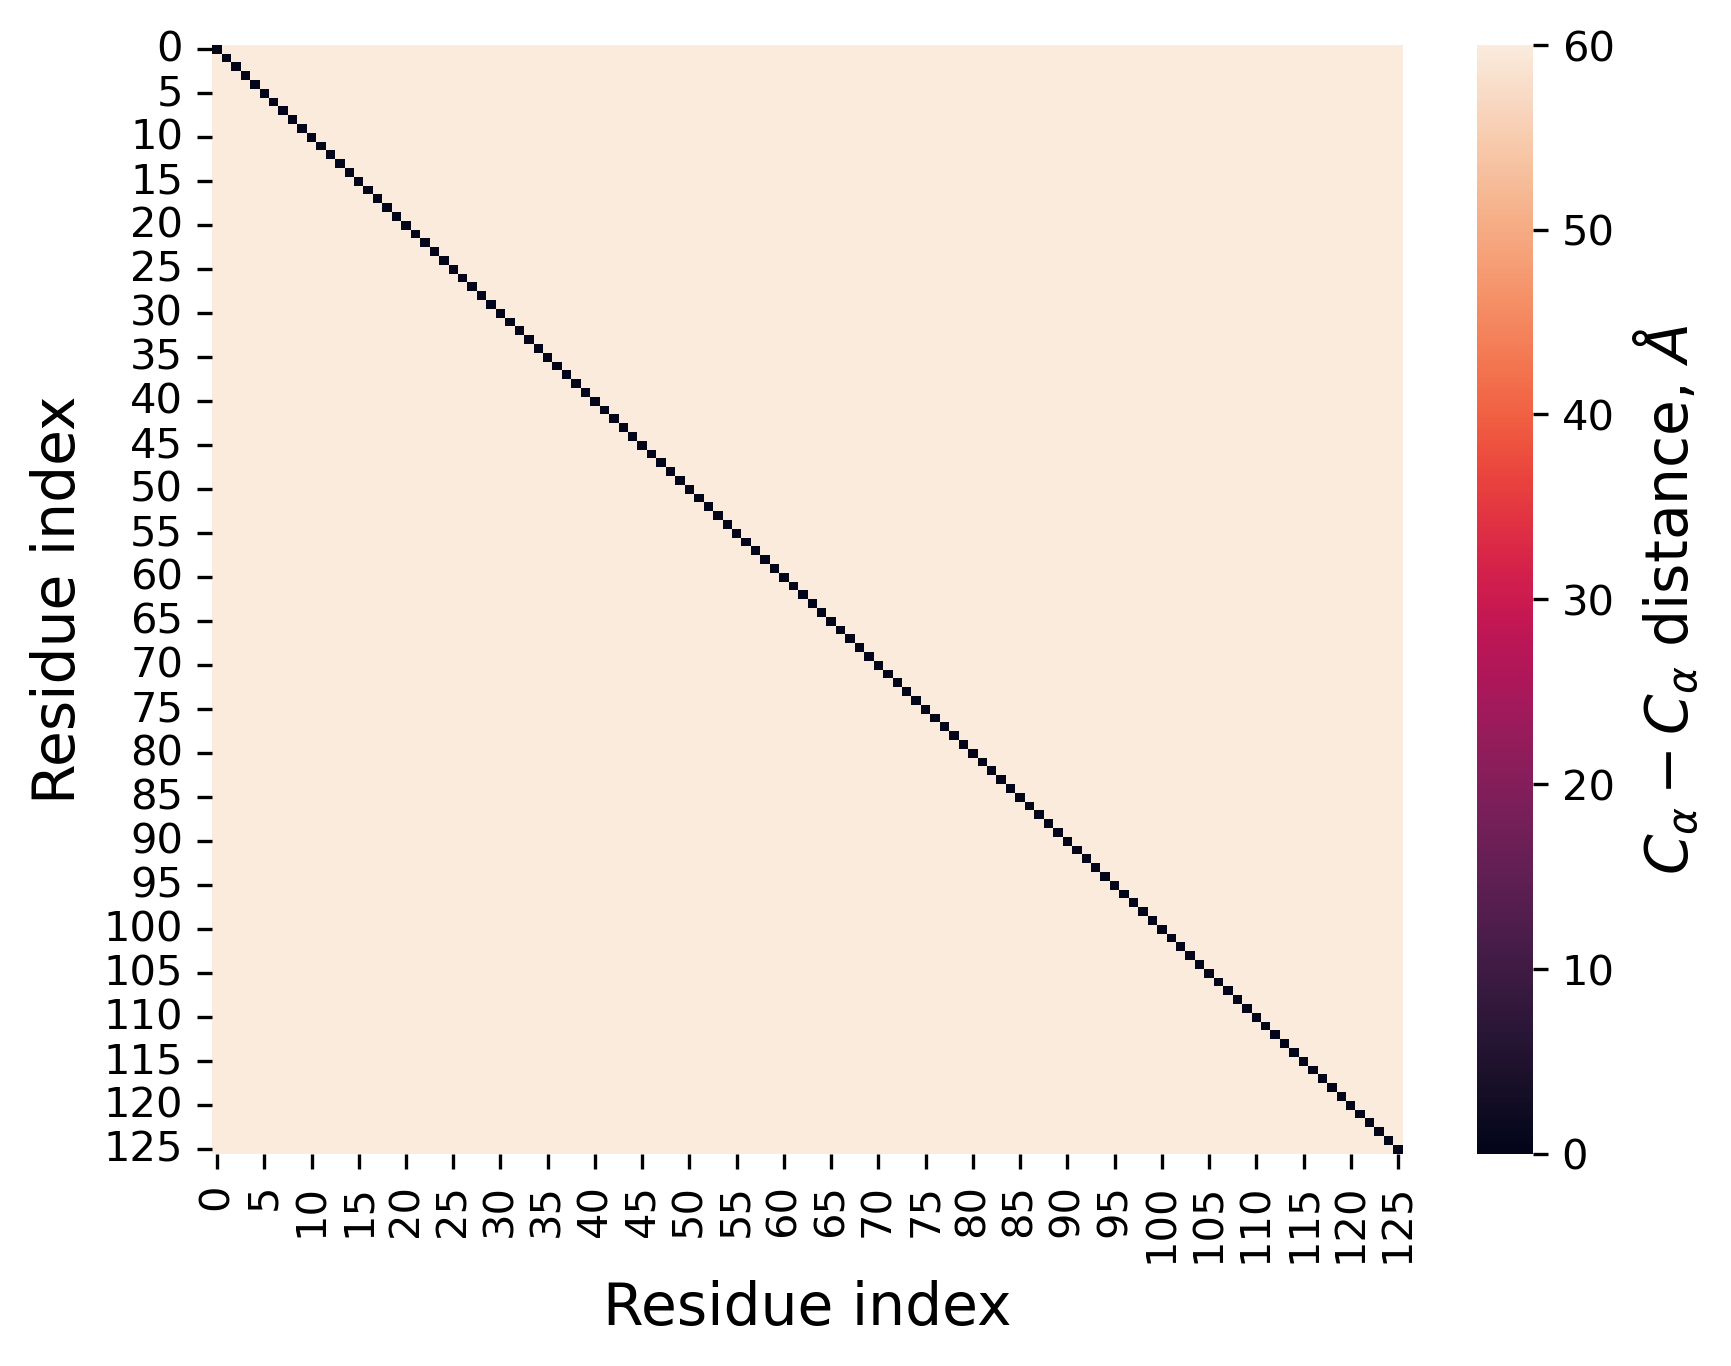

In [79]:
def pairwise_dist_heatmap(alpha_carbon_coords, fname: str = "", title: str = "", **kwargs):
    """
    Get the pairwise distances and draw a heatmap
    """
    pdists = pairwise.euclidean_distances(alpha_carbon_coords)
    pdists_flat = pdists[np.triu_indices_from(pdists, k=1)]
    print(np.mean(pdists_flat), np.max(pdists_flat))

    fig, ax = plt.subplots(dpi=300)
    ax = sns.heatmap(
        pdists,
        ax=ax,
        # xticklabels=[],
        # yticklabels=[],
        **kwargs,
    )
    ax.collections[0].colorbar.set_label(r"$C_\alpha-C_\alpha$ distance, $\AA$", fontsize=14)
    ax.set_ylabel("Residue index", fontsize=14)
    ax.set_xlabel("Residue index", fontsize=14)
    if title:
        ax.set_title(title, fontsize=16)
    if fname:
        fig.savefig(fname, bbox_inches='tight')
    return fig

pairwise_dist_heatmap(
    final_sampled[0],
    vmin=0., vmax=60.,
    # title="Cartesian",
    fname=PLOT_SUBDIR / "pairwise_dist_cartesian_baseline.pdf"
).show()

23.514162 59.466114


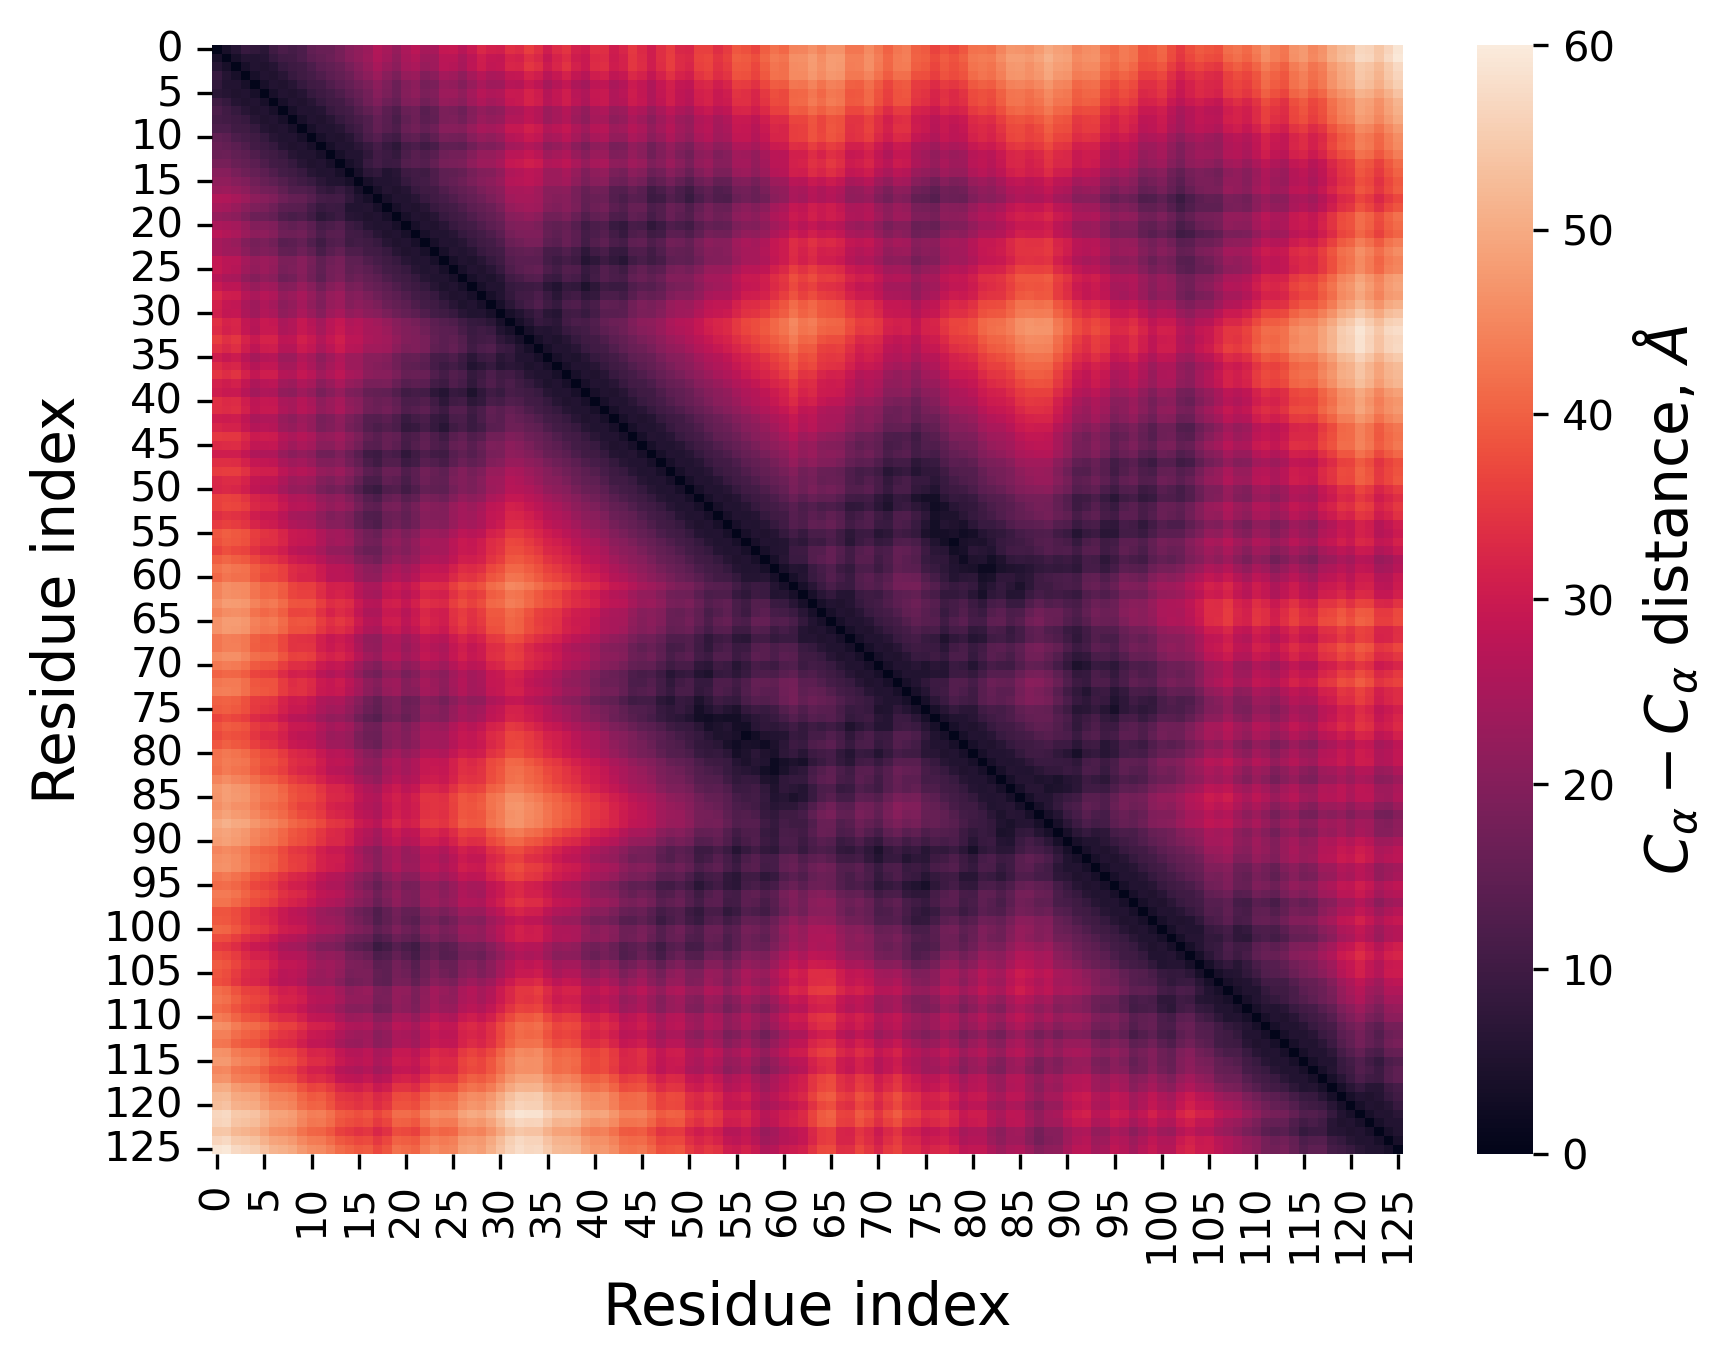

In [80]:
# Load in a baseline

generated_backbone = ac.extract_backbone_coords(
    "/home/wukevin/projects/protdiff_results/generation-cosine-epoch-1488-sweep/sampled_pdb/generated_760.pdb",
    atoms=['CA']
)

pairwise_dist_heatmap(
    generated_backbone,
    vmin=0., vmax=60.,
    # title_suffix=r"$C_\alpha$ pairwise distance, ours",
    fname=PLOT_SUBDIR / "pairwise_dist_ours.pdf"
).show()

/home/wukevin/miniconda3/envs/protdiff/lib/python3.8/site-packages/biotite/structure/io/pdb/file.py:419: UserWarning: 1769 elements were guessed from atom_name.
  warn("{} elements were guessed from atom_name.".format(rep_num))


20.068687 54.09612


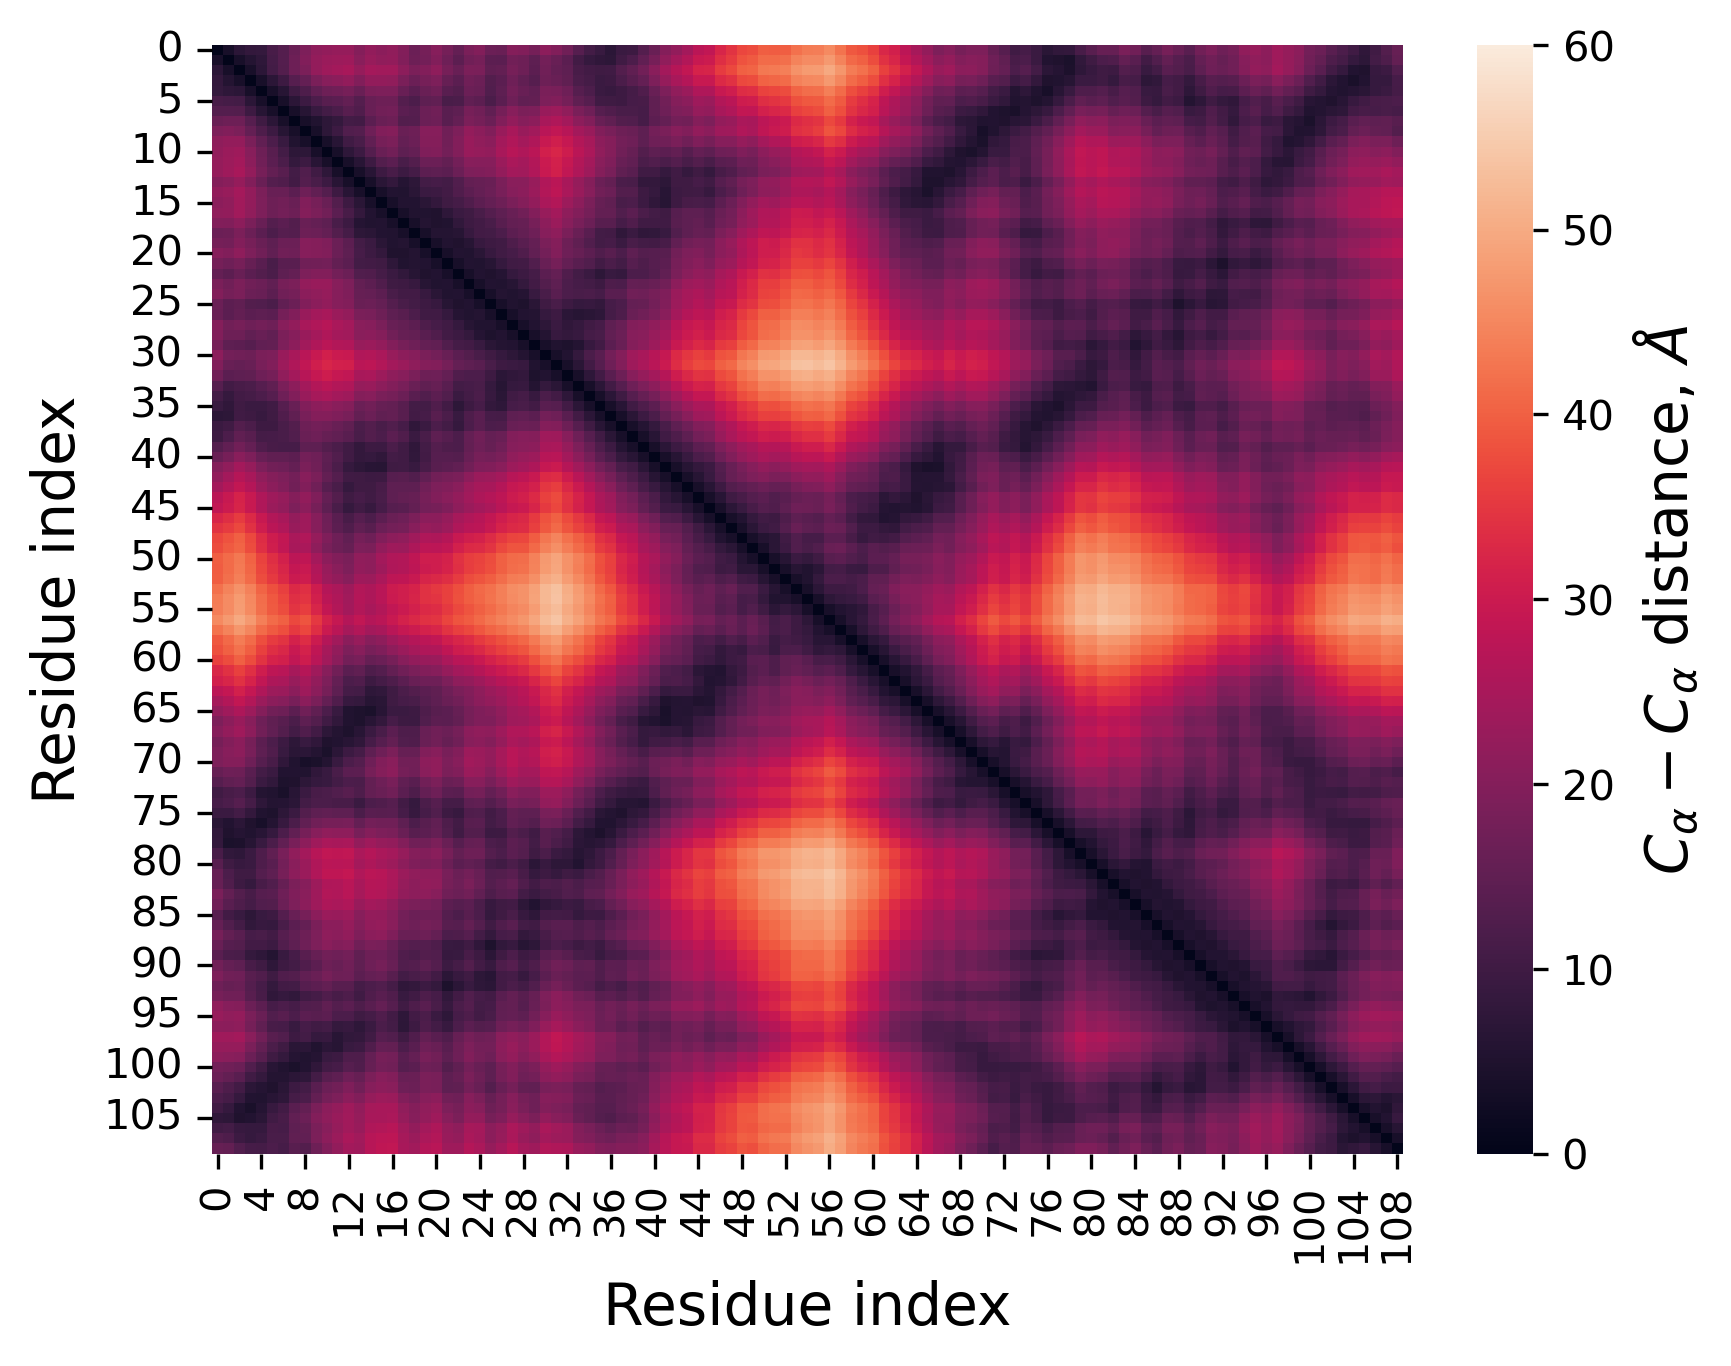

In [81]:
# Load in a referenc backbone

real_backbone = ac.extract_backbone_coords(train_dset.filenames[1], atoms=['CA'])
pairwise_dist_heatmap(
    real_backbone,
    vmin=0., vmax=60.,
    # title_suffix=r"$C_\alpha$ pairwise distance, ours",
    fname=PLOT_SUBDIR / "pairwise_dist_real.pdf"
).show()